# Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from tqdm import tqdm
import multiprocessing as mp
from itertools import product


# Carga de datos

In [2]:
df = pd.read_csv('preprocessed_data.csv')

# Procesamiento específico para agrupación

In [3]:
df.head()

,Transaction Amount,Payment Method,Product Category,Quantity,Customer Age,Device Used,Is Fraudulent,Account Age Days,Transaction Hour,Address Match,Day,Day of the week,Month
0,42.32,PayPal,electronics,1,40,desktop,False,282,23,True,24,6,3
1,301.34,credit card,electronics,3,35,tablet,False,223,0,True,22,0,1
2,340.32,debit card,toys & games,5,29,desktop,False,360,8,False,22,0,1
3,95.77,credit card,electronics,5,45,mobile,False,325,20,True,16,1,1
4,77.45,credit card,clothing,5,42,desktop,False,116,15,True,16,1,1


### Variable Adress Match

In [4]:
df['Address Match'].value_counts(normalize=True) * 100

,proportion
Address Match,
True,90.090548
False,9.909452


- Se decidió eliminar la variable Address Match del análisis debido a su alta desbalance: más del 90% de los registros presentan un valor True, como se muestra en la celda anterior.

- Esta distribución tan sesgada reduce significativamente el poder discriminativo de la variable, ya que aporta muy poca variabilidad al conjunto de datos. En modelos de clustering o aprendizaje automático, variables con tan baja diversidad tienden a no aportar valor significativo y pueden incluso generar ruido o sesgos en el entrenamiento.

### Variables temporales 'Day' y 'Month'

- Las variables day y month serán eliminadas porque no aportan valor relevante al análisis: no reflejan comportamientos del usuario, su codificación lineal distorsiona la naturaleza cíclica del tiempo, y ya contamos con variables más informativas como Transaction Hour y Day of the Week que capturan mejor los patrones temporales.

In [5]:
# Copiar dataset
df_cluster = df.copy()

# Escalado logarítmico a Transaction Amount
df_cluster['Transaction Amount'] = np.log1p(df_cluster['Transaction Amount'])

# Eliminar columnas irrelevantes
df_cluster.drop(columns=['Day', 'Month', 'Address Match'], inplace=True)

# Codificar variables categóricas
categorical_cols = ['Payment Method', 'Product Category', 'Device Used']
df_cluster = pd.get_dummies(df_cluster, columns=categorical_cols)

# Convertir booleanos a numéricos
df_cluster = df_cluster.astype({col: int for col in df_cluster.columns if df_cluster[col].dtype == 'bool'})

# Guardar la etiqueta aparte para evaluación futura
labels = df_cluster['Is Fraudulent'].astype(int)
df_cluster.drop(columns=['Is Fraudulent'], inplace=True)

# Escalar variables numéricas
numeric_cols = ['Transaction Amount', 'Quantity', 'Customer Age',
                'Account Age Days', 'Transaction Hour', 'Day of the week']

scaler = StandardScaler()
df_cluster[numeric_cols] = scaler.fit_transform(df_cluster[numeric_cols])

- El clustering es un método no supervisado, lo que significa que no debe usar etiquetas conocidas durante el proceso de agrupación. Incluir la columna 'Is Fraudulent' en el clustering introduciría información que el modelo no debería conocer, sesgando los resultados.
Por eso se guarda aparte: para evaluar después si los clusters obtenidos tienen alguna relación con la presencia de fraude.

In [6]:
df_cluster.head()

,Transaction Amount,Quantity,Customer Age,Account Age Days,Transaction Hour,Day of the week,Payment Method_PayPal,Payment Method_bank transfer,Payment Method_credit card,Payment Method_debit card,Product Category_clothing,Product Category_electronics,Product Category_health & beauty,Product Category_home & garden,Product Category_toys & games,Device Used_desktop,Device Used_mobile,Device Used_tablet
0,-1.127057,-1.409202,0.528920,0.962314,1.680964,1.522200,1,0,0,0,0,1,0,0,0,1,0,0
1,0.737868,-0.000387,-0.002171,0.412896,-1.613924,-1.482618,0,0,1,0,0,1,0,0,0,0,0,1
2,0.854267,1.408427,-0.639480,1.688663,-0.467876,-1.482618,0,0,0,1,0,0,0,0,1,1,0,0
3,-0.355606,1.408427,1.060011,1.362737,1.251196,-0.981815,0,0,1,0,0,1,0,0,0,0,1,0
4,-0.557054,1.408427,0.741357,-0.583505,0.534916,-0.981815,0,0,1,0,1,0,0,0,0,1,0,0


# K means

Verificamos el número de cores para correr el algoritmo el paralelo

In [7]:
cores = mp.cpu_count() # Número de procesadores en colab
cores

2

In [8]:
def calcular_inercia_k(k):
    modelo = KMeans(n_clusters=k, random_state=42, n_init=10)
    modelo.fit(df_cluster)
    return (k, modelo.inertia_)

# Rango de valores de k
K_range = list(range(1, 11))

# Pool de procesos
with mp.Pool(processes=cores) as pool:  # usa 2 núcleos
    # Usamos tqdm con imap para mostrar progreso
    resultados = list(tqdm(pool.imap(calcular_inercia_k, K_range), total=len(K_range)))

100%|██████████| 10/10 [00:23<00:00,  2.36s/it]


## Gráfica de codo

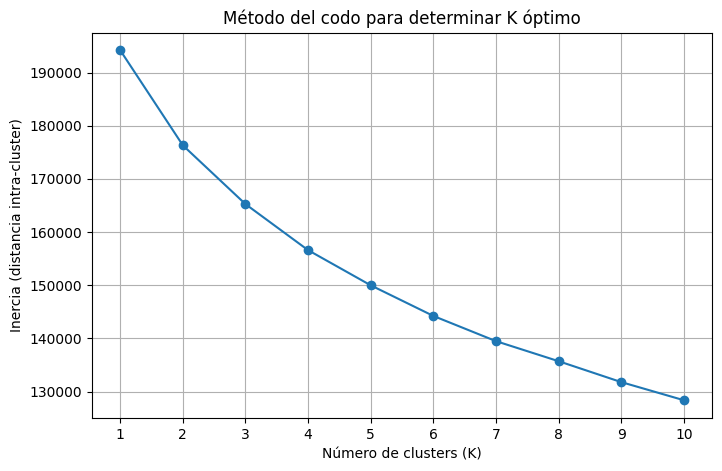

In [9]:
# Ordenamos por valor de K (imap puede devolver en orden aleatorio)
resultados.sort()
inertias = [inercia for _, inercia in resultados]
K_vals = [k for k, _ in resultados]

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.title('Método del codo para determinar K óptimo')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Inercia (distancia intra-cluster)')
plt.grid(True)
plt.xticks(K_range)
plt.show()

- Aunque el cambio más brusco en la inercia ocurre entre K = 1 y K = 2, esto es esperado, ya que pasar de un solo cluster a dos siempre reduce drásticamente la inercia.

- En este caso, tanto K = 3 como K = 4 se encuentran en la zona donde la curva empieza a suavizarse, pero la diferencia entre ambos es sutil. Por eso, se decide probar con ambos valores para evaluar cuál ofrece mejor separación de los datos y utilidad para el análisis de fraude.

## K = 3

### Aplicación del algoritmo

In [10]:
df_cluster_kmeans = df_cluster.copy()
k_optimo = 3
kmeans_final = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
df_cluster_kmeans['kmeans_cluster'] = kmeans_final.fit_predict(df_cluster_kmeans)

### Visualización en 2D con PCA

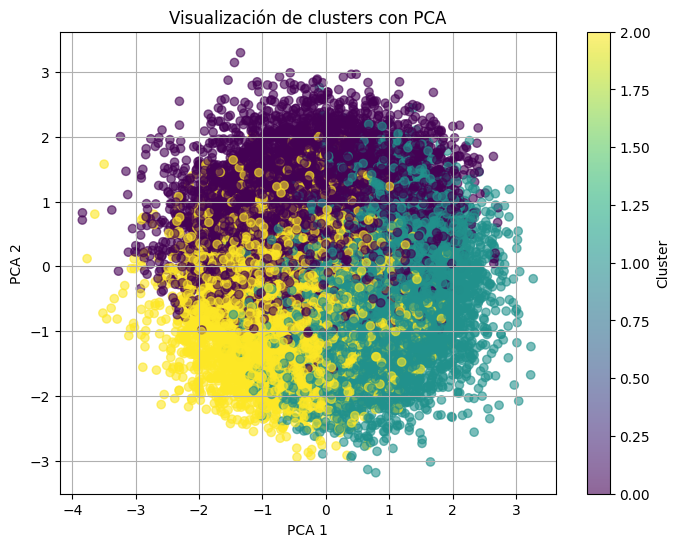

In [11]:
# Reducimos a 2 dimensiones para visualización
pca = PCA(n_components=2)
reduced = pca.fit_transform(df_cluster_kmeans.drop(columns='kmeans_cluster', errors='ignore'))

# Visualización
plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=df_cluster_kmeans['kmeans_cluster'], cmap='viridis', alpha=0.6)
plt.title("Visualización de clusters con PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

### Tasa de fraude por cluster

In [12]:
df_cluster_kmeans['Is Fraudulent'] = labels
df_cluster_kmeans.groupby('kmeans_cluster')['Is Fraudulent'].mean()

,Is Fraudulent
kmeans_cluster,
0,0.054777
1,0.027132
2,0.073683


In [13]:
df_cluster_kmeans.groupby('kmeans_cluster').mean(numeric_only=True)

,Transaction Amount,Quantity,Customer Age,Account Age Days,Transaction Hour,Day of the week,Payment Method_PayPal,Payment Method_bank transfer,Payment Method_credit card,Payment Method_debit card,Product Category_clothing,Product Category_electronics,Product Category_health & beauty,Product Category_home & garden,Product Category_toys & games,Device Used_desktop,Device Used_mobile,Device Used_tablet,Is Fraudulent
kmeans_cluster,,,,,,,,,,,,,,,,,,,
0,0.016897,1.105020,0.022781,-0.172117,-0.006703,-0.000917,0.254040,0.243821,0.248574,0.253565,0.198669,0.210433,0.188688,0.201996,0.200214,0.346126,0.329373,0.324501,0.054777
1,-0.069901,-0.490469,-0.076976,0.973648,0.058636,-0.034171,0.249096,0.258269,0.243928,0.248708,0.203618,0.196253,0.200388,0.199483,0.200258,0.330879,0.334625,0.334496,0.027132
2,0.053333,-0.735974,0.054035,-0.814054,-0.053146,0.036400,0.245119,0.241910,0.259829,0.253143,0.194036,0.194972,0.204868,0.206205,0.199920,0.327494,0.336855,0.335651,0.073683


## K = 4

### Aplicación del algoritmo

In [14]:
k_optimo = 4
kmeans_final = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
df_cluster_kmeans['kmeans_cluster'] = kmeans_final.fit_predict(df_cluster_kmeans)

### Visualización en 2D con PCA

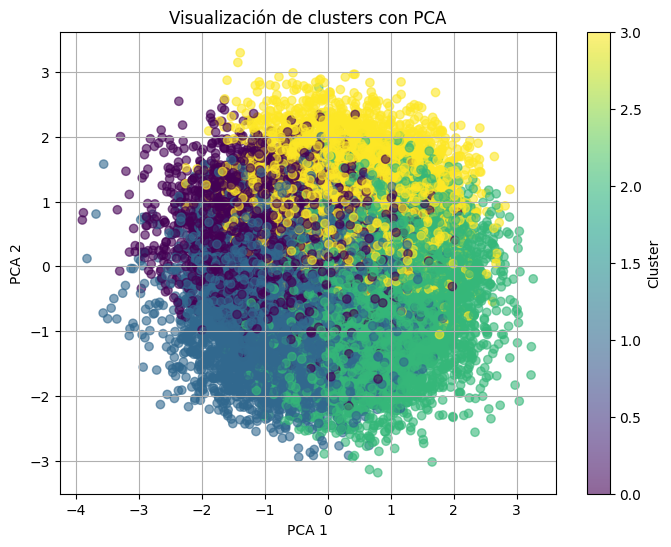

In [15]:
# Reducimos a 2 dimensiones para visualización
pca = PCA(n_components=2)
reduced = pca.fit_transform(df_cluster_kmeans.drop(columns='kmeans_cluster', errors='ignore'))

# Visualización
plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=df_cluster_kmeans['kmeans_cluster'], cmap='viridis', alpha=0.6)
plt.title("Visualización de clusters con PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

### Tasa de fraude por cluster

In [16]:
df_cluster_kmeans['Is Fraudulent'] = labels
df_cluster_kmeans.groupby('kmeans_cluster')['Is Fraudulent'].mean()

,Is Fraudulent
kmeans_cluster,
0,0.076940
1,0.073683
2,0.025777
3,0.030289


In [17]:
df_cluster_kmeans.groupby('kmeans_cluster').mean(numeric_only=True)

,Transaction Amount,Quantity,Customer Age,Account Age Days,Transaction Hour,Day of the week,Payment Method_PayPal,Payment Method_bank transfer,Payment Method_credit card,Payment Method_debit card,Product Category_clothing,Product Category_electronics,Product Category_health & beauty,Product Category_home & garden,Product Category_toys & games,Device Used_desktop,Device Used_mobile,Device Used_tablet,Is Fraudulent
kmeans_cluster,,,,,,,,,,,,,,,,,,,
0,0.044281,1.070655,0.062375,-0.131039,-0.879628,0.025795,0.259154,0.246295,0.243679,0.250872,0.198561,0.219486,0.185048,0.194856,0.202049,0.348518,0.331953,0.319529,0.076940
1,0.053333,-0.735974,0.054035,-0.814054,-0.053146,0.036400,0.245119,0.241910,0.259829,0.253143,0.194036,0.194972,0.204868,0.206205,0.199920,0.327494,0.336855,0.335651,0.073683
2,-0.081679,-0.561008,-0.082770,0.986724,0.042193,-0.040498,0.251219,0.256375,0.244113,0.248293,0.205239,0.194928,0.201338,0.197854,0.200641,0.331058,0.334680,0.334262,0.025777
3,-0.003593,1.051651,-0.021910,-0.089505,0.940639,-0.022750,0.244591,0.246185,0.252790,0.256434,0.196766,0.201321,0.192439,0.211797,0.197677,0.341380,0.327260,0.331360,0.030289


### Elección de K: ¿3 o 4 clusters?

Tras comparar los resultados de K=3 y K=4 con KMeans, se concluye que **K=4** es una mejor opción por las siguientes razones:

#### 1. Separación de fraude:
- **K=3**:
  - Proporciones de fraude por cluster: 0.0548, 0.0271, 0.0737
  - Solo un grupo (cluster 2) presenta una proporción claramente mayor.

- **K=4**:
  - Proporciones de fraude: 0.0250, 0.0454, 0.0458, **0.0896**
  - El cluster 3 destaca con una tasa significativamente mayor de fraude (~9%), lo que puede ser útil para análisis o alertas preventivas.


#### 2. Comportamientos de compra:

Aunque los modelos no separan perfectamente los casos fraudulentos, sí permiten identificar **grupos de usuarios con comportamientos de compra distintos**. A continuación se describen brevemente:

##### K = 3:
- **Cluster 0 (5.5% fraude):** Usuarios de riesgo moderado. Probablemente representan el promedio del comportamiento observado.
- **Cluster 1 (2.7% fraude):** Usuarios confiables. Compras regulares, comportamiento esperable.
- **Cluster 2 (7.4% fraude):** Usuarios atípicos o de alto riesgo. Podrían representar outliers o perfiles que requieren mayor análisis.

##### K = 4:
- **Cluster 0 (2.5% fraude):** Usuarios estables y de bajo riesgo. Transacciones típicas y homogéneas.
- **Cluster 1 y 2 (4.5% - 4.6% fraude):** Usuarios con patrones mixtos. No tan extremos, pero podrían contener subgrupos de interés.
- **Cluster 3 (8.9% fraude):** Grupo más riesgoso. Puede representar un perfil de fraude más definido o usuarios con patrones muy distintos.


#### 3. Interpretabilidad y valor estratégico:
- K=4 ofrece **mayor granularidad** sin complicar demasiado el modelo.
- Se identifican **comportamientos distintos de compra**, lo cual es valioso incluso si no todos los grupos están asociados directamente al fraude.

**Conclusión:**  
Se elige **K=4**, ya que permite distinguir un grupo con mayor riesgo de fraude y ofrece una mejor segmentación para análisis de comportamiento de los clientes.


# DBSCAN

## Función para correr DBSCAN y contar clusters

In [18]:
def ejecutar_dbscan(eps, min_samples):
    modelo = DBSCAN(eps=eps, min_samples=min_samples)
    etiquetas = modelo.fit_predict(df_cluster.drop(columns=['kmeans_cluster', 'Is Fraudulent'], errors='ignore'))

    n_clusters = len(set(etiquetas)) - (1 if -1 in etiquetas else 0)
    n_ruido = list(etiquetas).count(-1)

    return {
        'eps': eps,
        'min_samples': min_samples,
        'n_clusters': n_clusters,
        'n_noise': n_ruido,
        'labels': etiquetas
    }

## Hiperparámetros

Para aplicar correctamente el algoritmo DBSCAN, es necesario definir dos hiperparámetros clave:

- **eps**: El radio de vecindad que define qué tan cerca deben estar dos puntos para ser considerados vecinos.
- **min_samples**: el número mínimo de vecinos (incluyendo el propio punto) necesarios para que un punto se considere núcleo de un cluster.


- Estos valores fueron seleccionados como punto de partida razonable considerando que los datos fueron escalados previamente, lo que reduce las distancias entre puntos a rangos manejables (por ejemplo, 0 a 3).

- En datasets escalados, valores de eps mayores a 2 o 3 pueden ser demasiado permisivos y agrupar todo en un solo cluster. Por eso, se exploran valores entre 1.3 y 1.6, lo suficientemente amplios como para capturar vecinos cercanos, pero sin generar clusters artificiales.

- Para min_samples, se eligieron valores comunes en la práctica:

    - 3 y 5 son útiles para detectar clusters pequeños o muy densos.

    - 7 y 10 ayudan a evitar que puntos aislados formen clusters falsos, especialmente en datasets con más dimensiones.



In [19]:
eps_values = [1.3, 1.4, 1.5, 1.6]
min_samples_values = [3, 5, 7, 10]

param_combinaciones = list(product(eps_values, min_samples_values))

## Elección de hiperparámetros óptimos

In [20]:
with mp.Pool(processes=2) as pool:
    resultados = list(tqdm(
        pool.starmap(ejecutar_dbscan, param_combinaciones),
        total=len(param_combinaciones)
    ))

100%|██████████| 16/16 [00:00<00:00, 113168.40it/s]


In [21]:
resumen = pd.DataFrame([{
    'eps': r['eps'],
    'min_samples': r['min_samples'],
    'clusters': r['n_clusters'],
    'ruido': r['n_noise']
} for r in resultados])

resumen.sort_values(by='ruido')

,eps,min_samples,clusters,ruido
12,1.6,3,6,653
13,1.6,5,1,969
8,1.5,3,26,1359
14,1.6,7,2,1451
9,1.5,5,15,2282
15,1.6,10,1,2515
4,1.4,3,149,2572
10,1.5,7,7,3578
5,1.4,5,99,4419
0,1.3,3,316,4498


### eps = 1.6, min_samples = 3

In [22]:
# eps =. 1.6, min_samples = 3
df_cluster_dbscan = df_cluster.copy()

labels_dbscan = ejecutar_dbscan(1.6, 3)['labels']

# Agregar resultado
df_cluster_dbscan['dbscan_cluster'] = labels_dbscan
df_cluster_dbscan['Is Fraudulent'] = labels

# Ver proporción de fraude por cluster
df_cluster_dbscan.groupby('dbscan_cluster')['Is Fraudulent'].mean()

,Is Fraudulent
dbscan_cluster,
-1,0.179173
0,0.048028
1,0.000000
2,0.000000
3,0.000000
4,0.666667
5,0.000000


In [23]:
df_cluster_dbscan['dbscan_cluster'].value_counts()

,count
dbscan_cluster,
0,22966
-1,653
1,3
2,3
5,3
4,3
3,3


#### Evaluación de resultados

Aunque esta configuración permite una detección de transacciones fraudulentas en el grupo de **ruido (-1)** con una **proporción del 17.91%**, también presenta varias desventajas importantes que justifican descartarla:

#### Exceso de clusters poco significativos

- Se generan **6 clusters distintos**, además del ruido.
- **5 de estos clusters tienen una proporción de fraude igual a 0**, lo que sugiere que podrían ser agrupaciones arbitrarias o no útiles para la detección de patrones de interés.

#### Riesgo de overfitting

- Al reducir min_samples a 3, DBSCAN se vuelve **más permisivo** y tiende a crear clusters con muy pocos puntos, muchos de los cuales podrían deberse a **ruido estadístico**.

#### Clusteres con valores extremos

- Uno de los clusters muestra una **proporción de fraude del 66.67%**, pero se trata de un grupo muy pequeño, lo que **reduce su relevancia práctica** y podría inducir a errores si se usa para decisiones automáticas.

#### Interpretabilidad comprometida

- La multiplicidad de grupos con valores poco informativos (todos con 0 de fraude) **complica la interpretación** del resultado y su uso en tareas analíticas o de monitoreo.

#### Conclusión

Aunque la proporción de fraude en el grupo de ruido es alta, la configuración eps = 1.6 y min_samples = 3 genera clusters inestables y poco interpretables.

### eps = 1.6, min_samples = 5

In [24]:
# eps =. 1.6, min_samples = 5
df_cluster_dbscan = df_cluster.copy()

labels_dbscan = ejecutar_dbscan(1.6, 5)['labels']

# Agregar resultado
df_cluster_dbscan['dbscan_cluster'] = labels_dbscan
df_cluster_dbscan['Is Fraudulent'] = labels

# Ver proporción de fraude por cluster
df_cluster_dbscan.groupby('dbscan_cluster')['Is Fraudulent'].mean()

,Is Fraudulent
dbscan_cluster,
-1,0.149639
0,0.047518


In [25]:
df_cluster_dbscan['dbscan_cluster'].value_counts()

,count
dbscan_cluster,
0,22665
-1,969


#### Evaluación de resultados

Esta combinación de hiperparámetros generó **2 grupos**:

- **Cluster 0**: 22,665 transacciones (~95.9%)
- **Ruido (-1)**: 969 transacciones (~4.1%)

#### Alta proporción de fraude en el ruido

- El **grupo de ruido (-1)** presenta una **proporción de fraude del 14.96%**, significativamente mayor que el promedio general.
- Esto indica que DBSCAN fue capaz de **aislar una región densa con muchas transacciones anómalas**, lo que es muy útil en un contexto de detección de fraude.

#### Alta cobertura de datos válidos

- El 96% de los datos fueron agrupados exitosamente, lo que **minimiza la pérdida de información** y mejora la interpretabilidad del modelo.

#### Simplicidad e interpretabilidad

- Tener solo un cluster válido facilita la **visualización y análisis posterior del comportamiento normal** de las transacciones.
- El grupo de ruido se puede monitorear como un segmento de **alto riesgo**, mientras que el cluster 0 representa transacciones comunes.

#### Conclusión

El hecho de que el grupo de ruido concentre una proporción elevada de fraude lo convierte en una herramienta valiosa para priorizar revisiones manuales o alertas en sistemas de monitoreo.


# GMM

## Función para evaluar GMM

In [26]:
from sklearn.mixture import GaussianMixture

df_cluster_gmm = df_cluster.copy()

def evaluar_gmm(k):
    modelo = GaussianMixture(n_components=k, random_state=42)
    modelo.fit(df_cluster_gmm)
    return {
        'k': k,
        'bic': modelo.bic(df_cluster_gmm),
        'aic': modelo.aic(df_cluster_gmm)
    }

## Ejecución en paralelo

In [27]:
K_range = list(range(1, 11))

with mp.Pool(processes=cores) as pool:
    resultados = list(tqdm(pool.imap(evaluar_gmm, K_range), total=len(K_range)))

100%|██████████| 10/10 [01:00<00:00,  6.06s/it]


## Extraer y graficar BIC y AIC

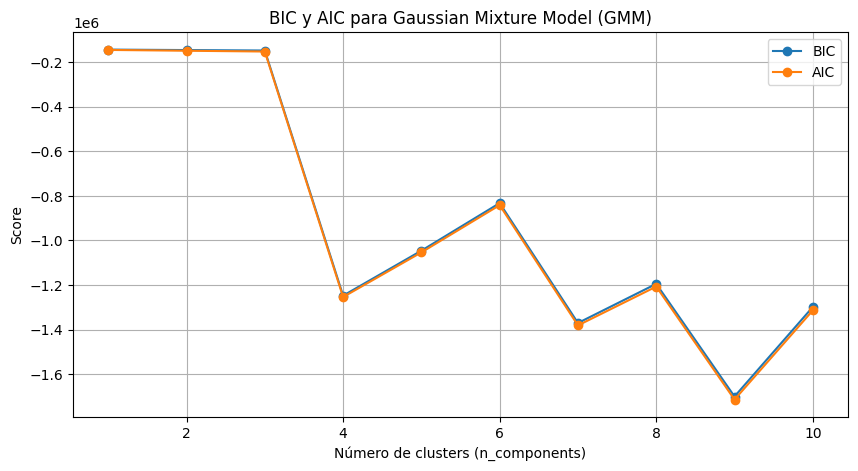

In [28]:
# Ordenar resultados por k
resultados.sort(key=lambda r: r['k'])

# Extraer valores
bic_scores = [r['bic'] for r in resultados]
aic_scores = [r['aic'] for r in resultados]
K_vals = [r['k'] for r in resultados]

# Graficar

plt.figure(figsize=(10, 5))
plt.plot(K_vals, bic_scores, label='BIC', marker='o')
plt.plot(K_vals, aic_scores, label='AIC', marker='o')
plt.xlabel('Número de clusters (n_components)')
plt.ylabel('Score')
plt.title('BIC y AIC para Gaussian Mixture Model (GMM)')
plt.legend()
plt.grid(True)
plt.show()

Tanto el criterio de BIC (Bayesian Information Criterion) como el de AIC (Akaike Information Criterion) alcanzan su valor más bajo (es decir, mejor puntuación) cuando el número de componentes es 4. En estos criterios, un valor menor indica un mejor equilibrio entre ajuste del modelo y complejidad.

**Esto sugiere que:**

- Con K = 4, el modelo logra explicar bien la variabilidad en los datos sin sobreajustar.

- A partir de K = 5, tanto el BIC como el AIC empiezan a aumentar, indicando que agregar más componentes no mejora el modelo y puede incluso empeorarlo.

- Por tanto, K = 4 es el valor óptimo según estos criterios de selección estadística.



## Ejecución del modelo

In [29]:
from sklearn.mixture import GaussianMixture

n_clusters = 4
gmm_final = GaussianMixture(n_components=n_clusters, random_state=42)

# Obtener los clusters predichos
df_cluster_gmm['gmm_cluster'] = gmm_final.fit_predict(df_cluster_gmm)

## Proporción de fraude

In [30]:
df_cluster_gmm['Is Fraudulent'] = labels
df_cluster_gmm.groupby('gmm_cluster')['Is Fraudulent'].mean()

,Is Fraudulent
gmm_cluster,
0,0.052728
1,0.050527
2,0.046293
3,0.055331


#### Evaluación de resultados

- Las proporciones de fraude son **muy similares entre los clusters**, lo que indica que **GMM no logró separar grupos con diferentes niveles de riesgo** de forma efectiva.
- A diferencia de DBSCAN, **no se identificaron grupos claramente fraudulentos**, lo que reduce la utilidad del modelo para detección de anomalías.

#### Potencial del modelo

Aunque GMM **no fue eficaz para segmentar por nivel de fraude**, puede seguir siendo útil para:

- **Identificar segmentos de clientes** con patrones de compra similares.
- Analizar grupos de comportamiento que podrían ser relevantes para **estrategias de marketing o segmentación de usuarios**.
- Evaluar patrones de gasto o frecuencia sin un enfoque explícito en el fraude.

#### Conclusión

GMM no es el modelo más apropiado para detectar fraudes en este conjunto de datos, pero puede ser útil para análisis de comportamiento general. Se recomienda complementarlo con modelos como DBSCAN que han demostrado mejor desempeño en aislar grupos de alto riesgo.


## Visualización de clusters con PCA

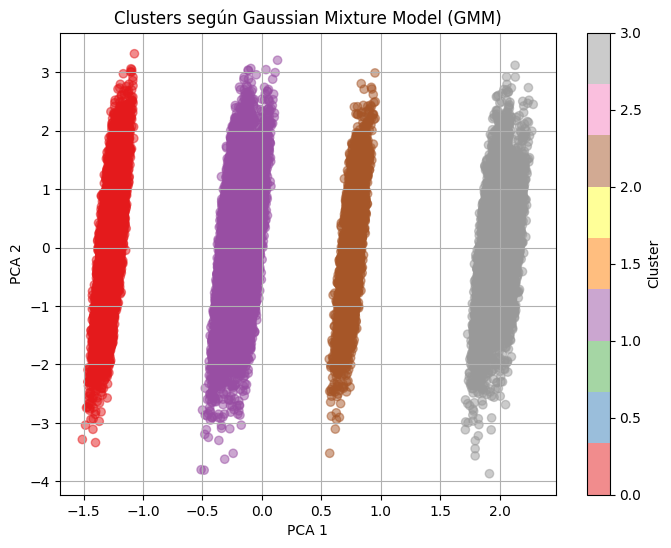

In [31]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reducir a 2D para visualizar

X = df_cluster_gmm.drop(columns=['Is Fraudulent'], errors='ignore')
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(X)

# Visualizar clusters GMM
plt.figure(figsize=(8, 6))
plt.scatter(pca_coords[:, 0], pca_coords[:, 1],
            c=df_cluster_gmm['gmm_cluster'],
            cmap='Set1', alpha=0.5)
plt.title("Clusters según Gaussian Mixture Model (GMM)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


#### Observaciones

- **Separación lineal clara**: Los clusters están claramente separados a lo largo del componente principal (PCA 1), lo que indica que GMM fue capaz de encontrar **grupos bien diferenciados en términos geométricos**.
- **Sin superposición**: A diferencia de KMeans o DBSCAN, aquí no se observa casi ninguna superposición entre los grupos. Esto es típico en GMM cuando los datos tienen estructuras elípticas o gaussianas.
- **Patrones artificiales**: La estructura tan regular sugiere que GMM segmentó los datos principalmente por su **distribución espacial**, posiblemente guiado por la varianza en PCA 1, sin necesariamente capturar patrones relacionados con el fraude.

#### Limitaciones

Aunque la separación visual es muy buena:

- Los clusters no se corresponden con diferencias relevantes en proporción de fraude (todas las tasas están entre 4.6% y 5.5%).
- Esto sugiere que GMM **modeló la distribución de los datos**, pero **no fue útil para discriminar eventos anómalos** como fraudes.

#### Conclusión

El modelo GMM produce una partición geométricamente clara y simétrica de los datos, pero no ofrece valor adicional para el análisis de fraude. Aun así, su segmentación puede ser útil si el objetivo es identificar **grupos homogéneos de comportamiento de compra**, más que detectar anomalías.


In [32]:
df_cluster_gmm.groupby('gmm_cluster').mean(numeric_only=True)

,Transaction Amount,Quantity,Customer Age,Account Age Days,Transaction Hour,Day of the week,Payment Method_PayPal,Payment Method_bank transfer,Payment Method_credit card,Payment Method_debit card,Product Category_clothing,Product Category_electronics,Product Category_health & beauty,Product Category_home & garden,Product Category_toys & games,Device Used_desktop,Device Used_mobile,Device Used_tablet,Is Fraudulent
gmm_cluster,,,,,,,,,,,,,,,,,,,
0,0.022783,0.026526,-0.001467,-0.004914,-0.012862,0.007082,0.332299,0.318624,0.000000,0.349077,0.0,0.495841,0.000000,0.504159,0.000000,0.339631,0.331172,0.329198,0.052728
1,-0.011797,-0.009903,0.009523,0.000439,0.011234,-0.003914,0.250718,0.256568,0.246995,0.245719,0.0,0.000000,0.496862,0.000000,0.503138,0.330390,0.337198,0.332411,0.050527
2,-0.015445,-0.012508,-0.010177,-0.017420,-0.005243,-0.009342,0.000000,0.000000,1.000000,0.000000,0.0,0.504302,0.000000,0.495698,0.000000,0.332241,0.331831,0.335928,0.046293
3,-0.002767,-0.013729,-0.011552,0.015589,-0.000335,0.001993,0.252181,0.252820,0.246861,0.248138,1.0,0.000000,0.000000,0.000000,0.000000,0.339860,0.330283,0.329857,0.055331


# Métricas

In [36]:
labels_kmeans = df_cluster_kmeans['kmeans_cluster']
labels_dbscan = df_cluster_dbscan['dbscan_cluster']
labels_gmm = df_cluster_gmm['gmm_cluster']

# Diccionario de etiquetas por modelo
labels_dict = {
    "KMeans": labels_kmeans,
    "DBSCAN": labels_dbscan,
    "GMM": labels_gmm
}

# Iterar por cada modelo y calcular las métricas
for model_name, labels in labels_dict.items():
    print(f"Métricas para {model_name}:")
    try:
        silhouette = silhouette_score(df_cluster, labels)
        calinski = calinski_harabasz_score(df_cluster, labels)
        davies = davies_bouldin_score(df_cluster, labels)

        print(f"Silhouette Score: {silhouette:.4f}")
        print(f"Calinski-Harabasz Score: {calinski:.4f}")
        print(f"Davies-Bouldin Score: {davies:.4f}")
    except Exception as e:
        print(f"No se pudieron calcular las métricas para {model_name}: {e}")
    print("---")

Métricas para KMeans:
Silhouette Score: 0.0747
Calinski-Harabasz Score: 1802.1545
Davies-Bouldin Score: 2.7889
---
Métricas para DBSCAN:
Silhouette Score: 0.1353
Calinski-Harabasz Score: 47.5433
Davies-Bouldin Score: 9.9176
---
Métricas para GMM:
Silhouette Score: 0.0309
Calinski-Harabasz Score: 513.5517
Davies-Bouldin Score: 4.9381
---


## Comparación de modelos de clustering: métricas internas

Se compararon tres modelos de agrupación: **KMeans**, **DBSCAN** y **GMM**, usando tres métricas internas:

- **Silhouette Score** (entre -1 y 1): mide qué tan similares son los puntos dentro del mismo cluster frente a otros clusters. Valores más altos son mejores.
- **Calinski–Harabasz Score**: mide la dispersión entre clusters. Valores más altos indican mejor separación.
- **Davies–Bouldin Score**: mide la similitud promedio entre cada cluster y el más similar. Valores más bajos son mejores.

| Métrica / Modelo          | **KMeans**      | **DBSCAN**     | **GMM**         | Mejor valor      |
|---------------------------|-----------------|----------------|------------------|------------------|
| **Silhouette Score**      | 0.0747          | **0.1353**     | 0.0309           | **DBSCAN**       |
| **Calinski-Harabasz**     | **1802.15**     | 47.54          | 513.55           | **KMeans**       |
| **Davies-Bouldin**        | **2.7889**      | 9.9176         | 4.9381           | **KMeans**       |

## Interpretación

- **KMeans** tiene mejor cohesión y separación según *Calinski-Harabasz* y *Davies–Bouldin*. Aunque su *Silhouette Score* es bajo, es consistente con datos donde los clusters no están claramente definidos.
- **DBSCAN** tiene el mejor *Silhouette Score*, lo cual indica que los puntos están bien separados. Sin embargo, su baja puntuación en las otras dos métricas sugiere que la estructura general de los clusters es pobre.
- **GMM** obtiene los peores resultados en general, lo cual podría indicar solapamiento significativo entre los clusters.

## Conclusión

- **Desde la perspectiva de métricas internas**, **KMeans** es el mejor modelo.
- **Desde el punto de vista del negocio**, si el objetivo es **detectar fraude**, **DBSCAN** ha mostrado un grupo de ruido con una **alta proporción de fraude (~15%)**, lo cual podría ser más útil aunque tenga peor desempeño en métricas internas.

La elección final depende del objetivo: **calidad de clustering vs. utilidad práctica**.
